In [ ]:
!pip install tensorflow_addons
import os
import tensorflow as tf
from tensorflow.keras.layers import (Dense,
                                     BatchNormalization,
                                     LeakyReLU,
                                     Reshape,
                                     Conv2DTranspose,
                                     Conv2D,
                                     Dropout,
                                     Flatten)
from tensorflow.keras.initializers import RandomNormal
from tensorflow_addons.layers import SpectralNormalization
import matplotlib.pyplot as plt
import time
from IPython import display

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.1 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
(images, labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = images.reshape(-1, 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

BUFFER_SIZE = 60000
BATCH_SIZE = 128

train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
def generator_model():
    model = tf.keras.Sequential()
    model.add(Dense(7*7*512, use_bias=False, input_shape=(100,), kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Reshape((7, 7, 512)))
    model.add(Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)))
    model.summary()
    return model

In [ ]:
generator = generator_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25088)             2508800   
                                                                 
 batch_normalization (Batch  (None, 25088)             100352    
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 25088)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 256)         3276800   
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 256)         1

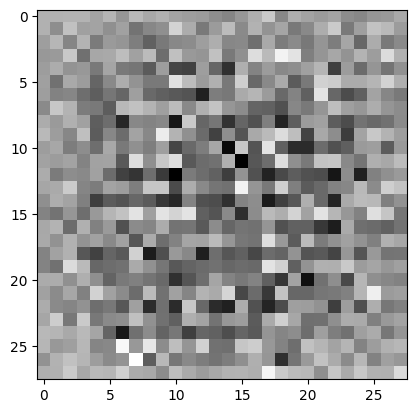

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(SpectralNormalization(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1], kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))))
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(SpectralNormalization(Conv2D(128, (5, 5), strides=(2, 2), padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))))
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(SpectralNormalization(Conv2D(256, (5, 5), strides=(2, 2), padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))))
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)))
    model(tf.keras.Input(shape=(28, 28, 1)))
    model.summary()
    return model

In [ ]:
discriminator = discriminator_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 spectral_normalization (Sp  (None, 14, 14, 64)        1728      
 ectralNormalization)                                            
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 spectral_normalization_1 (  (None, 7, 7, 128)         205056    
 SpectralNormalization)                                          
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)        

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def loss_discriminator(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def loss_generator(fake_output):
    fake_labels = tf.ones_like(fake_output)
    loss = cross_entropy(fake_labels, fake_output)
    return loss

# Optimizers for the generator and discriminator
learning_rate = 2e-4
generator_optimizer = tf.keras.optimizers.Adam(learning_rate)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate)

In [ ]:
save_dir = './model_checkpoints'
save_prefix = os.path.join(save_dir, "ckpt")
ckpt = tf.train.Checkpoint(gen_optimizer=generator_optimizer,
                           disc_optimizer=discriminator_optimizer,
                           gen_model=generator,
                           disc_model=discriminator)

total_epochs = 300
examples_to_generate = 16
noise_dim = 100
random_seed = tf.random.normal([examples_to_generate, noise_dim])

In [ ]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = loss_generator(fake_output)
    disc_loss = loss_discriminator(real_output, fake_output)
  gradients_of_generator = gen_tape.gradient(gen_loss,
                                            generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss,
                                            discriminator.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  predict = model(test_input, training=False)
  fig = plt.figure(figsize=(4,4))
  for i in range(predict.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predict[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  plt.savefig('image_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
def train(training_data, total_epochs):
    for epoch in range(total_epochs):
        start_time = time.time()

        for batch in training_data:
            train_step(batch)

        display.clear_output(wait=True)
        generate_and_save_images(generator,epoch+1,random_seed)


        if (epoch + 1) % 5 == 0:
            ckpt.save(file_prefix=save_prefix)

        print(f'Epoch {epoch + 1}/{total_epochs} - Time: {time.time() - start_time:.2f} sec')

    display.clear_output(wait=True)
    generate_and_save_images(generator, total_epochs,random_seed)


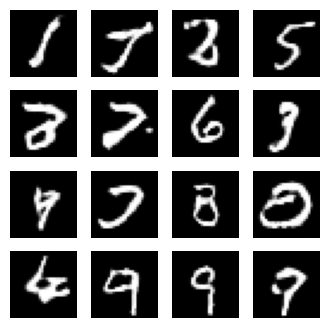

In [ ]:
train(train_dataset,total_epochs)